# Modeling objective

The modeling objective is to build and test a decision tree model that uses banking data to predict whether a customer will churn. If a customer churns, it means they left the bank and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do. These measures could be promotions, discounts, or other incentives to boost customer satisfaction, and, therefore, retention.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# This function displays the splits of the tree
from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [2]:
# Read in data

df = pd.read_csv(r"E:\google\Churn_Modelling.csv")
df.head(7)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0


In [3]:
#convert columns name to lower case letters
df.columns= df.columns.str.lower()

In [4]:
# Check class balance
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

# Model design and target variable

Our data dictionary shows that there is a column called `Exited`. This is a binary value that indicates whether or not a customer left the bank (0 = did not leave, 1 = did leave). This will be our target variable. In other words, for each customer, our model should predict whether they should have a 0 or a 1 in the `Exited` column.

This is a classification task, because we are trying to predict on a binary class. Therefore, we will use a `DecisionTreeClassifier` model.

The class of our target variable is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme. We will preserve this ratio when we model.

The data contains 10,000 observations, and the class distribution is approximately 80/20. 

Since we have some imbalance in our target classes, we know that if we measure model performance by accuracy alone, the model could predict 0 (no churn) 100% of the time and have an accuracy of ~80%. An accuracy of 80% might seem pretty good, but we know in this case it would be meaningless, because our model would fail to identify anybody who churned. Therefore, accuracy is not the best metric to use to evaluate our model's performance.  


To determine which evaluation metric might be best, consider how our model might be wrong. There are two possibilities for bad predictions: 
  
  - **False positives:** When the model predicts a customer **will** churn when in fact they won't
  - **False negatives:** When the model predicts a customer will **not** churn when in fact they will   
  

Precision represents the percentage of all our model's predicted positives that are true positives. This might not be the best metric for us to use, because it disincentivizes predicting someone will churn unless there is a high degree of certainty that they will. This could translate to a high rate of false negatives.

On the other hand, recall represents the percentage of all actual positives that the model identifies as such. This also might not be the best metric to use, because it rewards predicting someone will churn even if the likelihood of their doing so is very small. This could translate to a high rate of false positives.

So which is worse, false positives or false negatives? Well, we'd first have to define what _worse_ means. This is dependent on the details of the project that you're working on. For the sake of this exercise, let us suppose that we're defining it as the error that would cost the bank more money.

We can quickly get an idea of how much money each customer who churns costs the bank by calculating the average balance of all customers who churned.

In [5]:
# Calculate average balance of customers who churned
avg_churned_bal = df[df['exited']==1]['balance'].mean()
avg_churned_bal

91108.53933726068

This shows that the customers who churned each took with them €91,108.54, on average. That's a lot of money! This represents the average cost of the model predicting a false negative. 

What's the cost of predicting a false positive? Well, it's the cost of whatever the incentive might be to convince someone to stay with the bank when they were going to stay regardless of whether or not they were incentived. We don't have a number for this, and even if it's probably less than €91,108.54, it still could be thousands of Euros per customer in lost revenue, depending on the details of the incentive. 

Since correctly identifying customers who will churn is potentially very valuable, we *could* select recall as our most important metric. This might be a perfectly valid approach, depending on the specifics of the campaign. But this could also be problematic. After all, if we select a model based solely on recall, we could select a very biased model that predicts everyone to churn, but then 8,000 people would be given incentives needlessly.  

Since we don't know the exact cost of predicting a false negative, we'll make an assumption for this exercise. We'll assume that a metric that balances precision and recall is best. The metric that helps us achieve this balance is *F1 score*, which is defined as the harmonic mean of precision and recall. 

Again, there are many metrics to choose from. The important thing is that you make an informed decision that is based on your use case.

Now that we've decided on an evaluation metric, let's prepare the data for modeling.

# Feature selection

In [6]:
# Create a new df that drops RowNumber, CustomerId, Surname, and Gender cols
df1 = df.drop(['rownumber', 'customerid', 'surname', 'gender'], 
                            axis=1)

In [7]:
df1.head()

,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


# Feature transformation

Next, we'll dummy encode the `Geography` variable, which is categorical. There are three possible categories captured here: France, Spain, and Germany. When we call `pd.get_dummies()` on this feature, it will replace the `Geography` column with three new Boolean columns--one for each possible category contained in the column being dummied. 

When we specify `drop_first='True'` in the function call, it means that instead of replacing `Geography` with three new columns, it will instead replace it with two columns. We can do this because no information is lost from this, but the dataset is shorter and simpler.  

In this case, we end up with two new columns called `Geography_Germany` and `Geography_Spain`. We don't need a `Geography_France` column. Why not? Because if a customer's values in `Geography_Germany` and `Geography_Spain` are both 0, we'll know they're from France! 

In [8]:
# Dummy encode categorical variables
df1 = pd.get_dummies(df1, drop_first=True)

df1.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


It's time to split the data into features and target variable, and into training data and test data. We do this using the `train_test_split()` function. We'll put 25% of the data into our test set, and use the remaining 75% to train the model.

Don't forget to include the `stratify=y` parameter, as this is what ensures that the 80/20 class ratio of the target variable is maintained in both the training and test datasets after splitting.

Lastly, we set a random seed so we and others can reproduce our work.

In [9]:
# Define the y (target) variable
y = df1['exited']

# Define the X (predictor) variables
X = df1.copy()
X = X.drop('exited', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, stratify=y, 
                                                    random_state=42)

In [10]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

In [11]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.790
Precision: 0.486
Recall: 0.503
F1 Score: 0.494


In [12]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

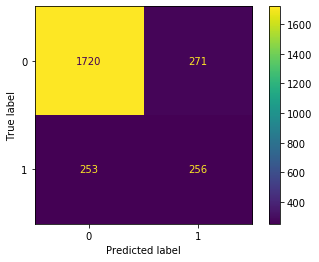

In [13]:
# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

Notice from this confusion matrix that the model correctly predicts many true negatives. Of course, this is to be expected, given that the dataset is imbalanced in favor of negatives. When the model makes an error, it appears slightly more likely to predict a false positive than a false negative, but it's generally balanced. This is reflected in the precision and recall scores both being very close to each other. 

# Plotting the tree

Next, let's examine the splits of the tree. We'll do this by using the `plot_tree()` function that we imported. We pass to it our fit model as well as some additional parameters. Note that if we did not set `max_depth=2`, the function would return a plot of the entire tree, all the way down to the leaf nodes. This is intractable and unnecessary. We're most interested in the splits nearest the root, because these tell us the most predictive features.

`class_names` displays what the majority class of each node is, and `filled` colors the nodes according to their majority class. 

Note that this plot represents how the tree grew from the _training data_. To make its predictions on the test data, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

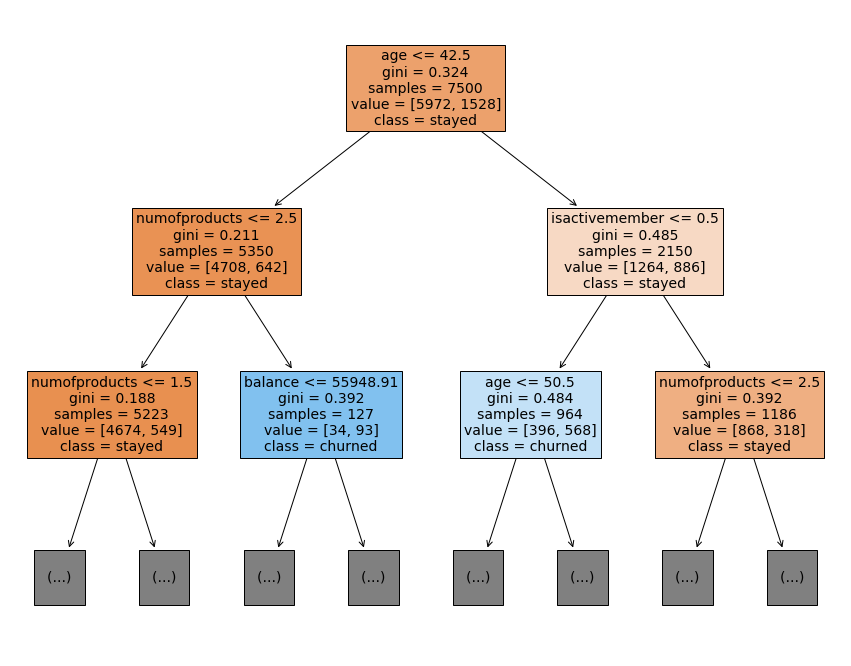

In [14]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'churned'}, filled=True);
plt.show()

How do we read this plot? The first line of information in each node is the feature and split point that the model identified as being most predictive. In other words, this is the question that is being asked at that split. For our root node, the question was: _Is the customer less than or equal to 42.5 years old?_

At each node, if the answer to the question it asks is "yes," the sample would move to the child node on the left. If the answer is "no," the sample would go to the child node on the right.

`gini` refers to the node's _Gini impurity_. This is a way of measuring how "pure" a node is. The value can range from 0 to 0.5. A Gini score of 0 means there is no impurity&mdash;the node is a leaf, and all of its samples are of a single class. A score of 0.5 means the classes are all equally represented in that node.

`samples` is simply how many samples are in that node, and `value` indicates how many of each class are in the node. Returning to the root node, we have `value = [5972, 1528]`. Notice that these numbers sum to 7,500, which is the number of samples in the node. This tells us that 5,972 customers in this node stayed (y=0) and 1,528 customers churned (y=1).

Lastly, we have `class`. This tells us the majority class of the samples in each node.

</br>  

This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their age.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors (relative to the features we have) of whether or not they will churn. 

This is a good indication that it might be worthwhile to return to your EDA and examine these features more closely. 

Finally, it's worth noting that there is no single question that can be asked&mdash;for any feature&mdash;that would cause a majority of samples in one of the child nodes to be of class "churned." The tree must get to depth two (i.e., two questions must be asked) before this happens.

# Tune and validate decision trees with Python

Topics of focus include:

* Using `GridSearchCV` to tune the following hyperparameters with cross-validation:
  - `max_depth`
  - `min_samples_leaf`

In [15]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [16]:
# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

In [17]:
# Assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [18]:
# Assign a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [19]:
%%time
# Instantiate the GridSearch
clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

# Fit the model
clf.fit(X_train, y_train)

Wall time: 19.6 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring={'f1', 'recall', 'accuracy', 'precision'})

In [20]:
# Examine the best model from GridSearch
clf.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20, random_state=42)

The `best_score_` attribute returns the best average F1 score across the different folds among all the combinations of hyperparameters. Note that if we had set `refit='recall'` when we instantiated our `GridSearchCV` object earlier, then calling `best_score_` would return the best recall score, and the best parameters might not be the same as what they are in the above cell, because the model would be selected based on a different metric.

In [21]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.5607


Although the F1 score of 0.561 is significantly better than the baseline model's F1 score of 0.494, it's not a fair comparison, because the baseline model was scored on the test data and the tuned model was scored against validation folds that came from the training data.

Recall that when we ran our grid search, we specified that we also wanted to capture precision, recall, and accuracy. The reason for doing this is that it's difficult to interpret an F1 score. These other metrics are much more directly interpretable, so they're worth knowing. 

The following cell defines a helper function that extracts these scores from the fit `GridSearchCV` object and returns a pandas dataframe with all four scores from the model with the best average F1 score during validation. This function will help us later when we want to add the results of other models to the table.

In [22]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [23]:
# Call the function on our model
result_table = make_results("Tuned Decision Tree", clf)

In [24]:
# Save table as csv
result_table.to_csv("Results.csv")

In [25]:
# View the results
result_table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.560655,0.469255,0.701608,0.8504


# These results show that our model's performance isn't great, but it's not terrible either. Maybe another kind of model will do better...